In [72]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from dataprep.eda import create_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



import lightgbm as lgb
from lightgbm import LGBMRegressor

In [93]:
dataset = pd.read_csv('cleaned-dataset2.csv')
dataset.head()

,Состояние,Бренд,Оперативная память (ГБ),Частота процессора,Количество ядер,Видеокарта,Тип,Накопитель,Объем накопителя,Price
0,Б/у,NotApple,8,2.7,4,4.7,Ультрабук,SSD,512,48000
1,Б/у,NotApple,2,1.2,2,4.7,Ноутбук,HDD,128,12000
2,Б/у,NotApple,2,2.2,2,4.7,Ноутбук,HDD,256,9500
3,Б/у,Apple,16,2.7,4,4.7,Ноутбук,SSD,256,34000
4,Б/у,NotApple,2,2.2,2,4.7,Ноутбук,HDD,512,14800


In [84]:
# data split 

dataset = dataset.astype({"Видеокарта": float})
dataset['Состояние'] = pd.Categorical(dataset['Состояние'])
dataset['Бренд'] = pd.Categorical(dataset['Бренд'])
dataset['Тип'] = pd.Categorical(dataset['Тип'])
dataset['Накопитель'] = pd.Categorical(dataset['Накопитель'])

features = dataset.drop('Price', axis=1)
target = dataset.Price



X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=999)

In [85]:
Model = LGBMRegressor(n_iterations=1000)

cv_method = StratifiedKFold(n_splits=5)


gridParams = {
    'learning_rate': [0.01, 0.1, 0.03, 0.3, 0.5],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : np.logspace(start=2, stop=9, num=8, endpoint=True, base=2, dtype=int),
    'random_state' : [42], 
    'metric':['r2'],
    
    }

# Create grid search object
Bayes_CV = RandomizedSearchCV(estimator=Model, param_distributions=gridParams, cv=cv_method, scoring=
        ['r2'], refit='r2', verbose=10, n_jobs=-1, n_iter=40, random_state=42)


# Fit on data
Bayes_CV.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMRegressor(n_iterations=1000), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.01, 0.1, 0.03, 0.3,
                                                          0.5],
                                        'max_depth': array([  4,   8,  16,  32,  64, 128, 256, 512]),
                                        'metric': ['r2'],
                                        'objective': ['regression'],
                                        'random_state': [42]},
                   random_state=42, refit='r2', scoring=['r2'], verbose=10)

In [ ]:
Bayes_CV.cv_results_    #['mean_test_r2']

In [69]:
results_KNN = pd.DataFrame(Bayes_CV.cv_results_['params'])
results_KNN['test_score'] = Bayes_CV.cv_results_['mean_test_r2']

In [70]:
del results_KNN['boosting_type']
del results_KNN['metric']
del results_KNN['random_state']
del results_KNN['objective']
results_KNN

,max_depth,learning_rate,test_score
0,4,0.01,0.596180
1,8,0.01,0.605601
2,16,0.01,0.605601
3,32,0.01,0.605601
4,64,0.01,0.605601
5,128,0.01,0.605601
6,256,0.01,0.605601
7,512,0.01,0.605601
8,4,0.10,0.764999
9,8,0.10,0.768297


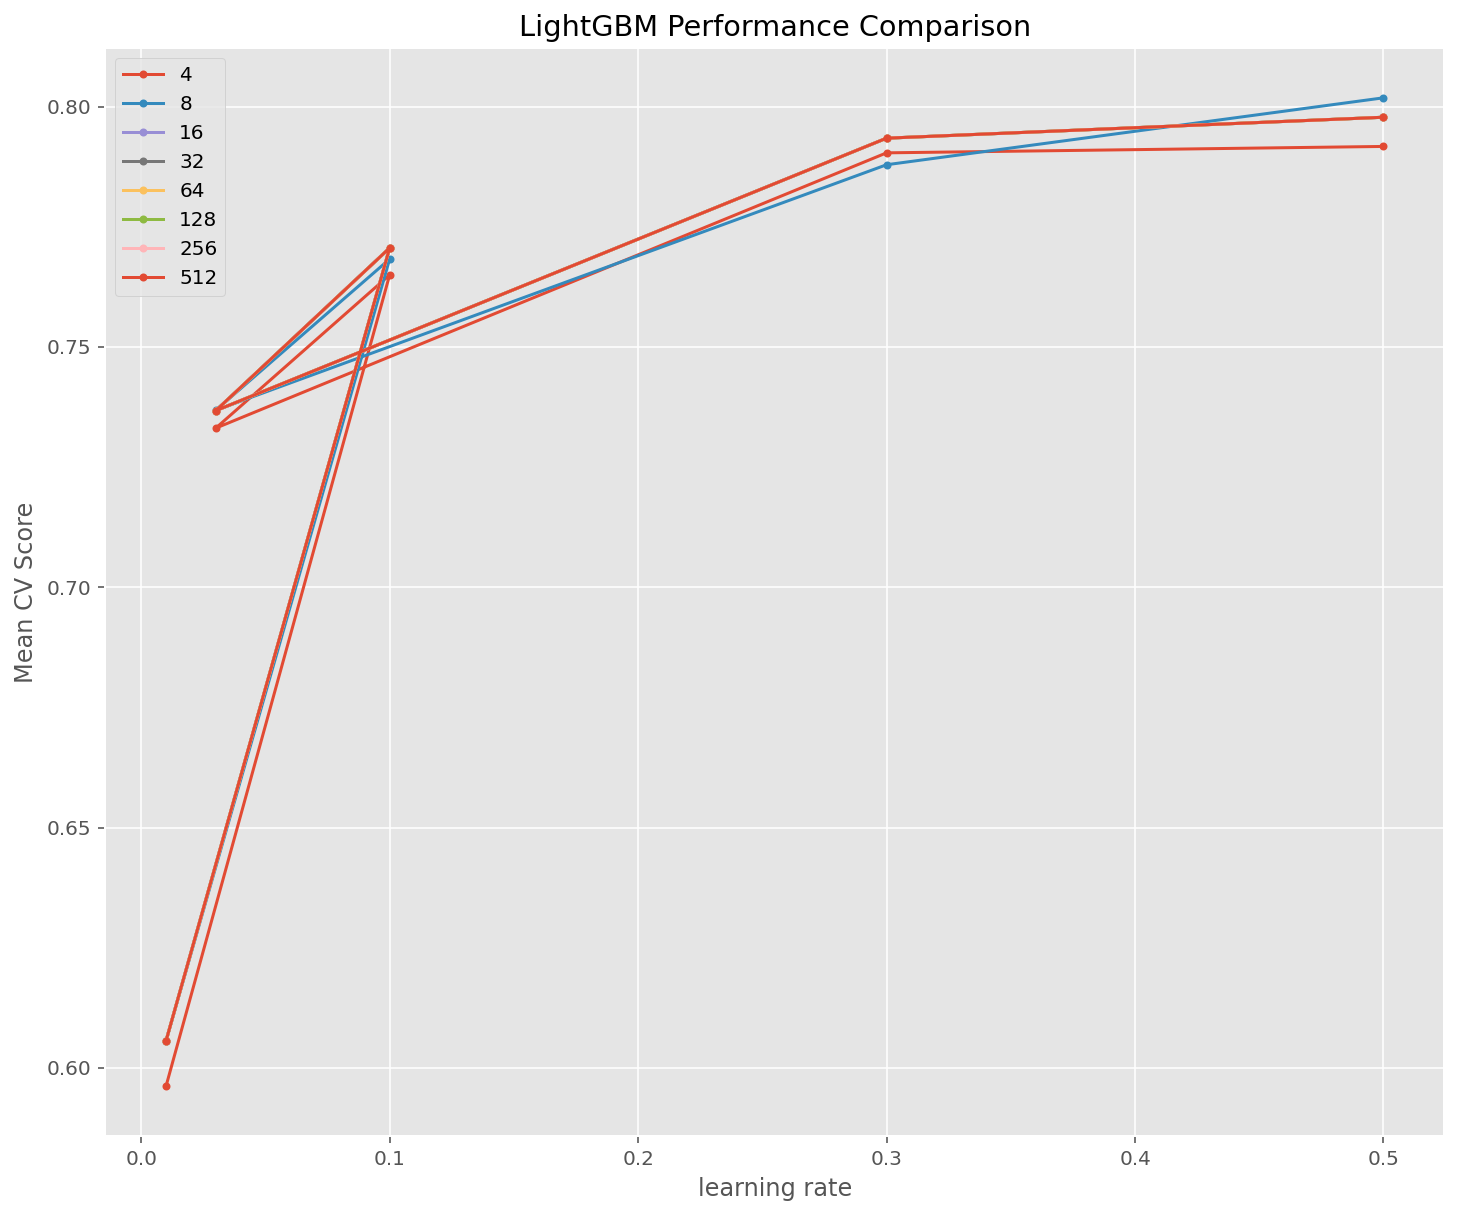

In [71]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.figure(figsize=(12,10))

for i in [  4,   8,  16,  32,  64, 128, 256, 512]:
    temp = results_KNN[results_KNN['max_depth'] == i]
    plt.plot(temp['learning_rate'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('learning rate')
plt.ylabel("Mean CV Score")
plt.title("LightGBM Performance Comparison")
plt.show()

In [86]:
print(f'Best Accuracy: {Bayes_CV.best_score_:.3f}\n')
print(f'Best parameter set: {Bayes_CV.best_params_}\n')


# Predict
BayesianRidge_prediction = Bayes_CV.predict(X_test)
print('MAE:', mean_absolute_error(y_test, BayesianRidge_prediction))

Best Accuracy: 0.802

Best parameter set: {'random_state': 42, 'objective': 'regression', 'metric': 'r2', 'max_depth': 8, 'learning_rate': 0.5, 'boosting_type': 'gbdt'}

MAE: 6964.815510644509


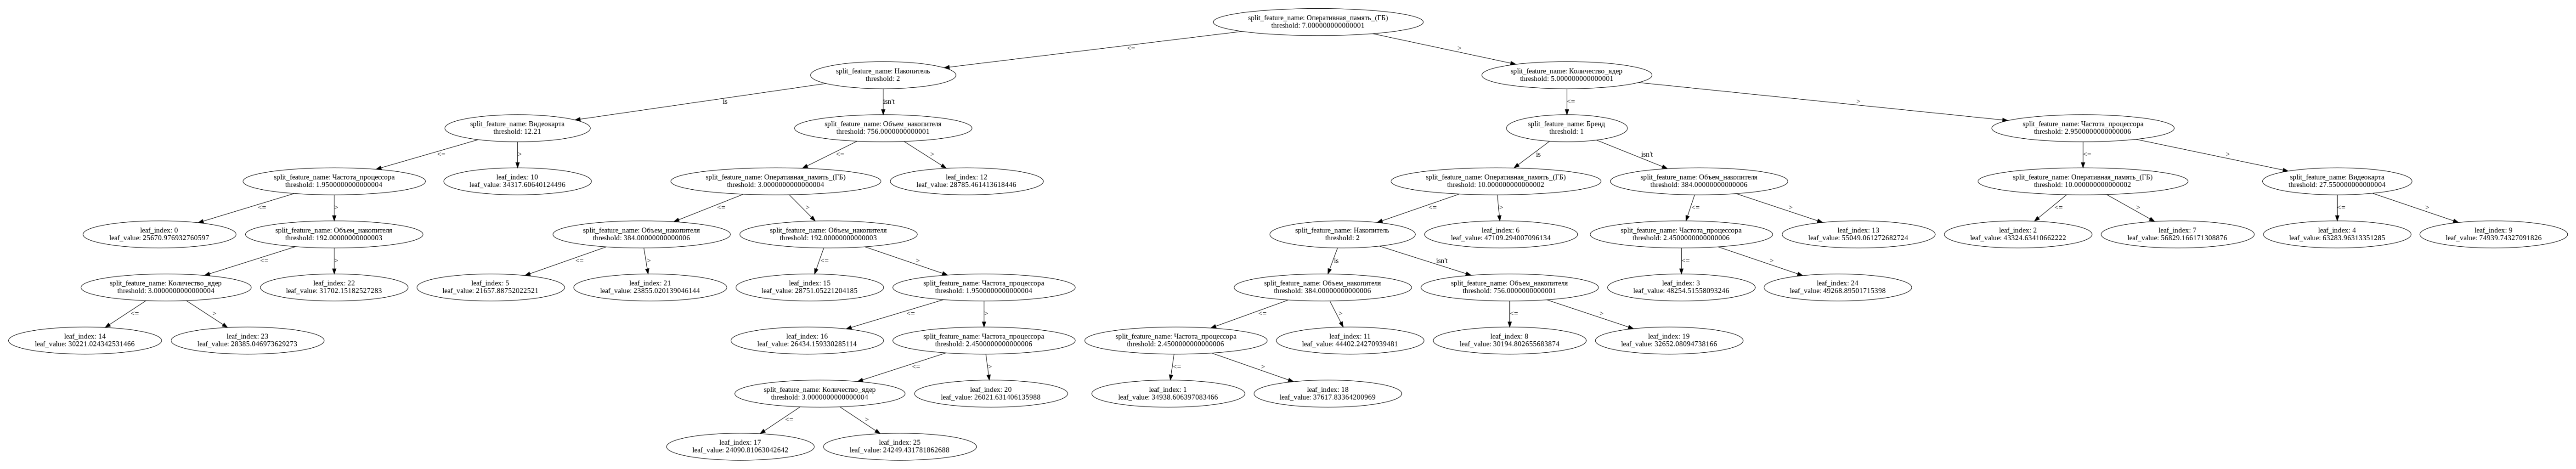

In [77]:
params = {'n_iterations':1000, 'random_state': 42, 'objective': 'regression', 'metric': 'r2', 'max_depth': 8, 'learning_rate': 0.5, 'boosting_type': 'gbdt'}
trees = LGBMRegressor(**params)
trees.fit(X_train, y_train)
_ = lgb.plot_tree(trees, figsize=(50, 30))

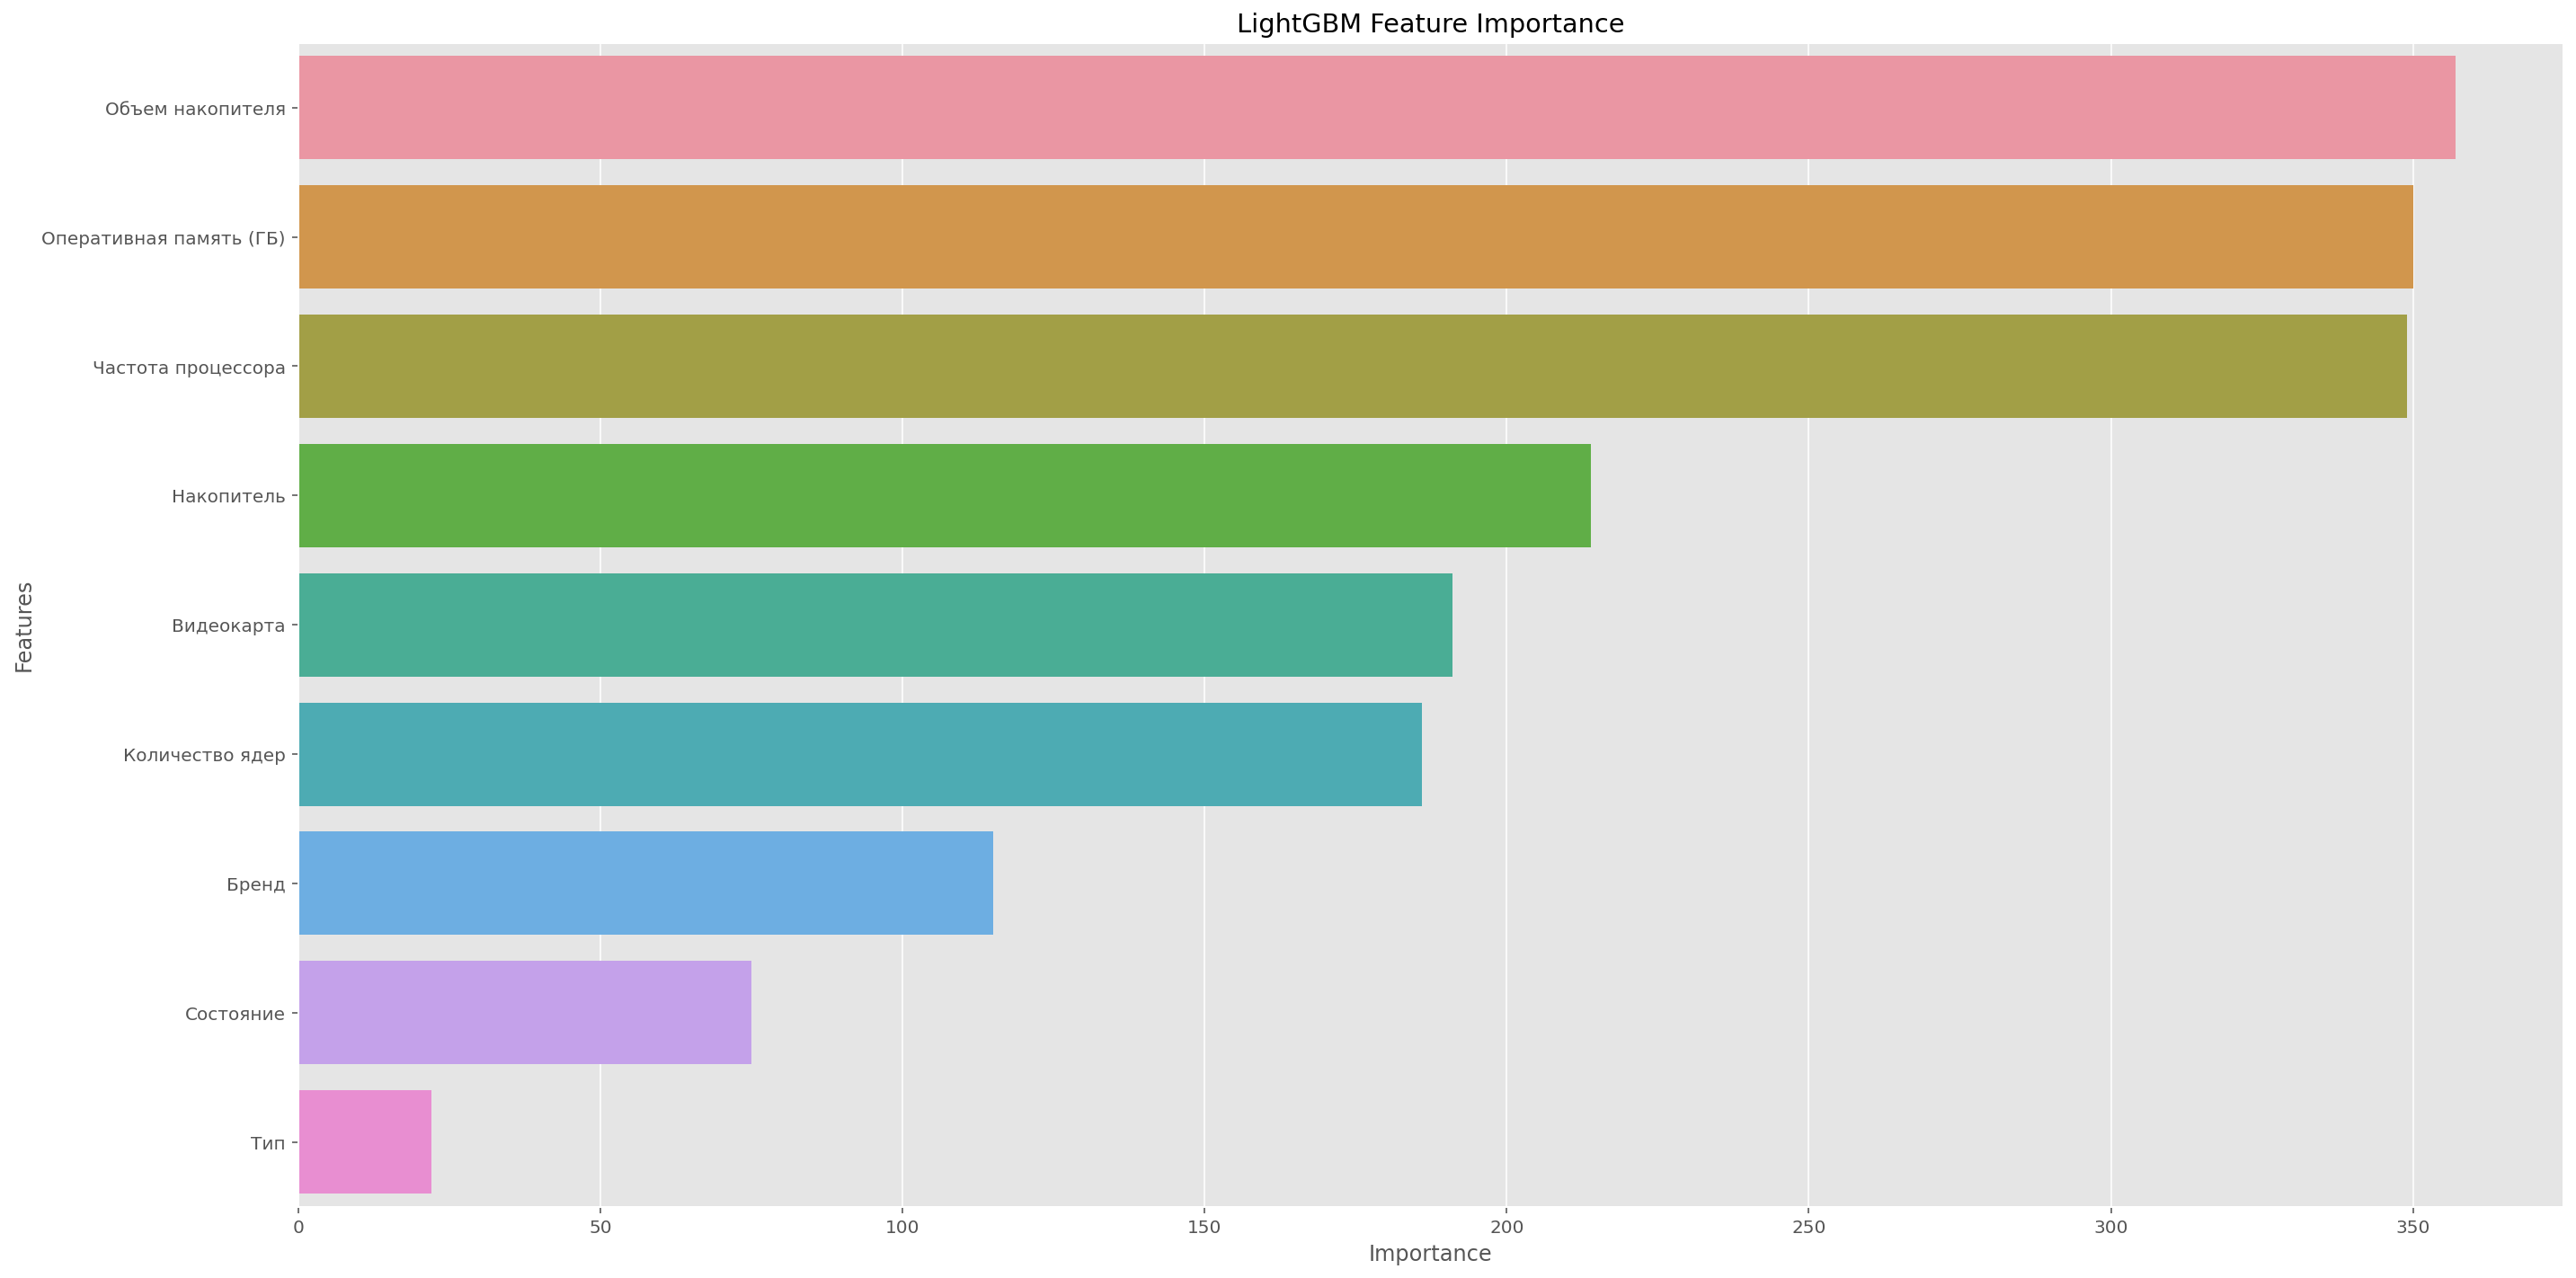

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(trees.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(trees.feature_importances_,dataset.columns)), columns=['Importance','Features'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Features", data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

In [94]:
trees.booster_.save_model('lgbm_weights.txt')

In [ ]:
newModel = lgb.Booster(model_file='lgbm_weights.txt')


def prepareRowForPrediction (rows, index):
  print(dataset['Состояние'].cat.categories)
  print(dataset['Бренд'].cat.categories)
  print(dataset['Тип'].cat.categories)
  print(dataset['Накопитель'].cat.categories)

  rows[index][0] = dataset['Состояние'].cat.categories.get_loc(rows[index][0])
  rows[index][1] = dataset['Бренд'].cat.categories.get_loc(rows[index][1] )
  rows[index][6] = dataset['Тип'].cat.categories.get_loc(rows[index][6] )
  rows[index][7] = dataset['Накопитель'].cat.categories.get_loc(rows[index][7])


# make a single prediction
rows = dataset.iloc[-10:-9, :-1]
print(rows)
rows = rows.to_numpy()
print(rows[0])
for index in range(len(rows)):
    prepareRowForPrediction(rows, index)

yhat = newModel.predict(rows)
yhat

     Состояние  Бренд  Оперативная память (ГБ)  Частота процессора  \
1371       Б/у  Apple                        8                 2.2   

      Количество ядер  Видеокарта        Тип Накопитель  Объем накопителя  
1371                4         4.7  Ультрабук        SSD               512  
['Б/у' 'Apple' 8 2.2 4 4.7 'Ультрабук' 'SSD' 512]
Index(['Б/у', 'На запчасти', 'Новый', 'Требуется ремонт'], dtype='object')
Index(['Apple', 'NotApple'], dtype='object')
Index(['Нетбук', 'Ноутбук', 'Ноутбук + планшет', 'Трансформер', 'Ультрабук'], dtype='object')
Index(['HDD', 'HDD + SSD', 'SSD', 'Другой тип накопителя'], dtype='object')


array([91862.21608606])

In [89]:
report = create_report(dataset)
report.save('EDA Report')

Report has been saved to EDA Report.html!
